In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import requests
import tensorflow as tf
from tensorflow.keras.applications.imagenet_utils import preprocess_input, decode_predictions
import matplotlib as mpl
import matplotlib.pyplot as plt

In [3]:
plt.style.use('ggplot')
mpl.rcParams['figure.figsize'] = (4, 4)
mpl.rcParams['axes.grid'] = False

# Load the model and its utilties function

In [4]:
def image_from_url(url, image_size):
    r = requests.get(url, stream=True)
    if r.status_code != requests.codes.ok:
        print("Image", url, "not found")
        return None
    else:
        image = tf.image.decode_image(r.content)
        image = tf.image.resize(image, image_size)
        # tf cast to float when resizing -- undoing
        image = tf.cast(image, 'uint8')
        return image

In [5]:
def get_predictions(model, batch):
    batch = tf.constant(batch)
    batch = tf.cast(batch, tf.float32)
    batch = preprocess_input(batch, mode='tf')
    return model.predict(batch)

In [6]:
def get_best_prediction(predictions):
    values, indices = tf.math.top_k(predictions[0])
    return {"class_id": int(indices[0]), "confidence": float(values[0])}

In [98]:
def display_predictions(predictions, top=5):
    """ Display image and its related model prediction if supplied
    top (int): many top-guesses to return.
    """

    # convinient utilties to lookup top predictions and its human labels 
    decoded_preds = decode_predictions(predictions, top=top)[0]
    
    labels = []
    x_pos = []
    probabilities = []
    for idx, label in enumerate(decoded_preds):
        labels.append(label[1])
        probabilities.append(label[2] * 100)
        x_pos.append(idx)


    plt.figure()

    plt.bar(x_pos, probabilities, color='blue')
    plt.xticks(rotation=45)
    plt.xlabel("Labels")
    plt.ylabel("Confidence (%)")
    plt.title("Model predictions")
    plt.xticks(x_pos, labels)

In [8]:
IMAGE_SIZE = (224, 224)
target_model = tf.keras.applications.MobileNetV2(include_top=True, weights='imagenet')
target_model.trainable = False

# Test model prediction

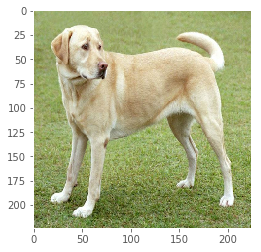

In [9]:
image_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/YellowLabradorLooking_new.jpg"
image = image_from_url(image_url, IMAGE_SIZE)
plt.imshow(image)

In [99]:
predictions = get_predictions(target_model, image[None, ...])
best_prediction = get_best_prediction(predictions)
print(best_prediction)

{'class_id': 208, 'confidence': 0.42222654819488525}


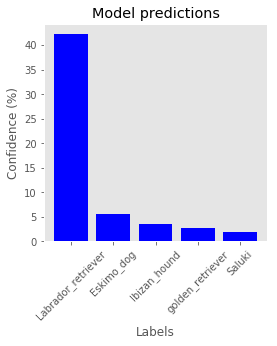

In [100]:
display_predictions(predictions)

# Define evolutionary model and its fitness function

In [12]:
from geneflow import GeneFlow
from geneflow.ops import Input, RandomMutations3D, UniformCrossover3D
from geneflow.selection import SelectFittest
from geneflow.fitness import FitnessFunction
import geneflow.backend as B
import numpy as np

Using cupy backend


In [13]:
from geneflow.fitness import Sum

In [70]:
class AdversarialImage(FitnessFunction):

    def __init__(self, target_model, target_image, predict_function, best_prediction_function, expected_best_prediction, **kwargs):
        """Compute the sum of the gene as fitness value.

        Args:
            model (fn): Function used to get model predictions.
            best_prediction_function (fn): function that return the best prediction out of set.
            best_prediction (dict): What is the expected class and its confidence in the normal case.
            
        Note:
            we use a predict_function and best_prediction_function to make the adversarial fitness function agnostic
            to the model used.
        """
        super(AdversarialImage, self).__init__('adversarial_image', **kwargs)
        self.model = target_model
        self.target_image = B.tensor(target_image)
        self.predict = predict_function
        self.get_best = best_prediction_function
        self.expected = expected_best_prediction
        

    def call(self, population):
        # FIXME add batch size.
        # predicts our population results
        population = B.as_numpy_array(population)
        predictions = self.predict(target_model, population)        
        # first we check the confidence value of the targeted class
        scores = []
        for idx, prediction in enumerate(predictions):
            best_pred = self.get_best(prediction[None, ...])
            
            # the mutated image still predict the correct class - so the lower the better
            if best_pred['class_id'] == self.expected['class_id']:
                score = 1 - best_pred['confidence']

            # the mutated image predict an incorrect class -- now we want to minimize the changes
            else:
                # FIXME: allows to use different diff function (mse, mae, huber, perceptual)
                mutated_image = B.tensor(population[idx])
                diff = (B.sum(B.abs(self.target_image - mutated_image))) / 100000
                score = 1 /diff  + 1 # +1 ensure a mutated image is always better ranked than an image producing same score
            scores.append(float(score))
        return B.tensor(scores)
            

In [71]:
# create population
POPULATION_SIZE = 4
image_numpy = np.array(image)

population = []
for _ in range(POPULATION_SIZE): 
    population.append(image_numpy)

population = np.array(population)
print(population.shape)

(4, 224, 224, 3)


In [72]:
# basic evolution graph
inputs = Input(shape=population.shape)
x = RandomMutations3D(max_gene_value=255, min_gene_value=0)(inputs)
outputs = UniformCrossover3D()(x)

In [73]:
gf = GeneFlow(inputs, outputs, debug=False)
gf.summary()


OP (type)                                       Output Shape      Inputs
----------------------------------------------  ----------------  ------------------------
input_0931E9 (Input)                            (4, 224, 224, 3)
randommutations3d_A6A50C (RandomMutations3D)    []                input_0931E9
uniformcrossover3d_28C1AF (UniformCrossover3D)  []                randommutations3d_A6A50C


In [74]:
evolution_strategy = SelectFittest()
fitness_fn = AdversarialImage(target_model, image_numpy, get_predictions, get_best_prediction, best_prediction)
gf.compile(evolution_strategy, fitness_fn)

In [78]:
results = gf.evolve(population, num_evolutions=1000)

In [79]:
print(results.get_latest_metrics())

{'fitness_mean': 1.0924841805809116, 'fitness_max': 1.0924841805809116}


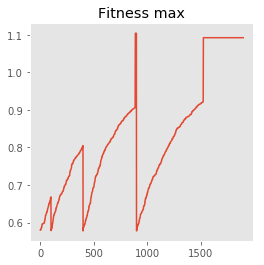

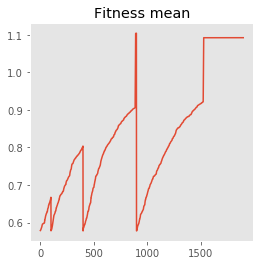

In [80]:
results.plot_metrics()

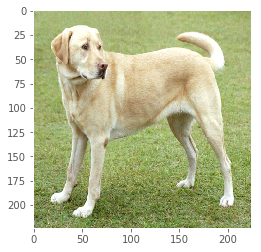

In [95]:
final_population = results.get_populations()
adversarial_img = B.as_numpy_array(final_population[0])
adversarial_img = adversarial_img.astype('uint8')
plt.imshow(adversarial_img)

In [101]:
predictions = get_predictions(target_model, adversarial_img[None, ...])
best_prediction = get_best_prediction(predictions)
print(best_prediction)

{'class_id': 173, 'confidence': 0.07927271723747253}


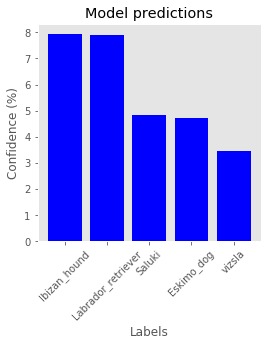

In [102]:
display_predictions(predictions)